# GNN + Human Feedback (REINFORCE 방식) 추천 시스템 개발

# 1. 라이브러리 임포트

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv

/opt/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. GNN 모델 정의

In [2]:
class HANPolicyRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64):
        super().__init__()
        self.han_conv = HANConv(-1, hidden_dim, metadata=metadata, heads=2)
        self.policy_head = nn.Linear(hidden_dim, 1)  # 추천 확률 출력

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.han_conv(x_dict, edge_index_dict)
        return self.policy_head(x_dict['visit_area']).squeeze(-1)

# 3. 데이터 구성

In [3]:
data_path = "../data/"

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

## 3-1. HeteroData 구성

In [4]:
hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

In [5]:
for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()
metadata

(['user', 'travel', 'visit_area'],
 [('user', 'traveled', 'travel'),
  ('travel', 'contains', 'visit_area'),
  ('visit_area', 'move_16', 'visit_area'),
  ('visit_area', 'move_15', 'visit_area'),
  ('visit_area', 'move_14', 'visit_area'),
  ('visit_area', 'move_10', 'visit_area'),
  ('visit_area', 'move_11', 'visit_area'),
  ('visit_area', 'move_13', 'visit_area'),
  ('visit_area', 'move_12', 'visit_area'),
  ('visit_area', 'move_8', 'visit_area'),
  ('visit_area', 'move_9', 'visit_area'),
  ('visit_area', 'move_1', 'visit_area'),
  ('visit_area', 'move_2', 'visit_area'),
  ('visit_area', 'move_3', 'visit_area'),
  ('visit_area', 'move_7', 'visit_area'),
  ('visit_area', 'move_6', 'visit_area'),
  ('visit_area', 'move_4', 'visit_area'),
  ('visit_area', 'move_5', 'visit_area')])

# 4. 모델, 옵티마이저 초기화

In [6]:
model = HANPolicyRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. GNN 출력 → softmax 확률 변환 → 샘플링

In [7]:
model.eval()
with torch.no_grad():
    logits_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    temperature = 2.0  # softmax 분포를 완화하기 위한 온도 파라미터
    probs_before = F.softmax(logits_before / temperature, dim=0)
    top_before = torch.topk(probs_before, k=5)
    print("[정책 이전] 추천 Top-5 장소 index:", top_before.indices.tolist())

[정책 이전] 추천 Top-5 장소 index: [406, 342, 843, 638, 875]


In [8]:
feedback_indices = top_before.indices.tolist()[2:3]  # 유저가 싫어한 추천 장소 인덱스
reward = -1.0  # 부정적 피드백

print("싫다고 한 것 : ", feedback_indices)

싫다고 한 것 :  [843]


In [9]:
for idx in feedback_indices:
    for step in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward
        loss.backward()
        optimizer.step()

# 6. REINFORCE 손실 계산 후 파라미터 업데이트

In [10]:
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    
print("[정책 이후] 추천 Top-5 장소 index:", top_after.indices.tolist())
print("보상 (reward):", reward)
print("REINFORCE loss:", round(loss.item(), 4))

[정책 이후] 추천 Top-5 장소 index: [386, 1510, 1511, 1509, 1508]
보상 (reward): -1.0
REINFORCE loss: -10.4084


# 7.추천 확률 분포 시각화

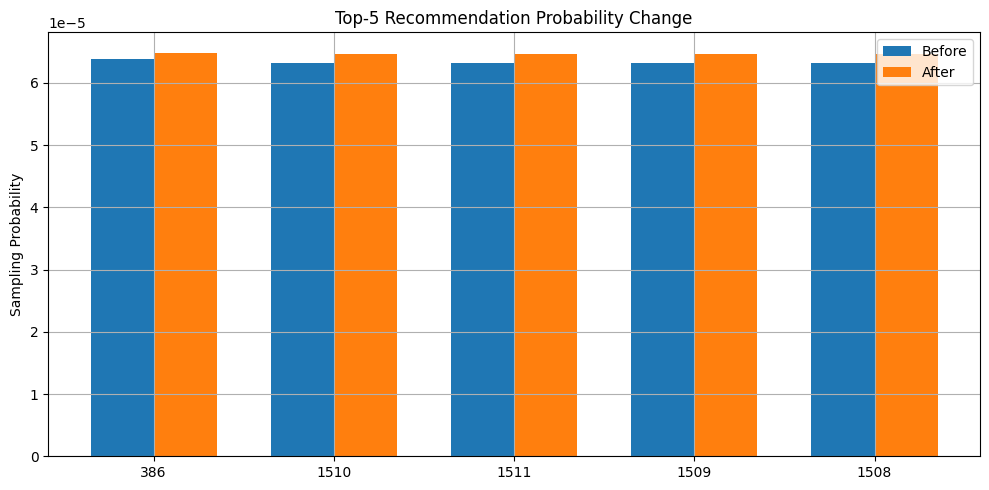

In [11]:
import matplotlib.pyplot as plt

indices = top_after.indices.tolist()
labels = [f"{i}" for i in indices]
before_vals = [probs_before[i].item() for i in indices]
after_vals = [probs_after[i].item() for i in indices]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, before_vals, width, label='Before')
ax.bar(x + width/2, after_vals, width, label='After')

ax.set_ylabel('Sampling Probability')  # Y축: 샘플링 확률
ax.set_title('Top-5 Recommendation Probability Change')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()  # 범례 표시
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# GNN + Human Feedback (YoSEMITE-inspired GNN 구조 적용 템플릿)

# ✅ 1. 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv
import os

# ✅ 2. YoSEMITE-style 정책 네트워크 정의 (GraphSAGE + Expert + Gate)
class YosemiteRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64):
        super().__init__()
        self.metadata = metadata

        self.conv1 = SAGEConv((-1, -1), hidden_dim)
        self.conv2 = SAGEConv((hidden_dim, hidden_dim), hidden_dim)

        # Expert 네트워크 2개 (위치 기반 / 취향 기반)
        self.expert_location = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.expert_preference = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # 게이트: 두 expert를 어떻게 섞을지
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x_dict, edge_index_dict):
        x = x_dict['visit_area']
        edge_index = edge_index_dict[('visit_area', 'move_1', 'visit_area')]  # 단일 타입 예시

        h = F.relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)

        loc_score = self.expert_location(h).squeeze(-1)
        pref_score = self.expert_preference(h).squeeze(-1)
        gate_weight = torch.softmax(self.gate(h), dim=-1)  # [N, 2]

        final_score = gate_weight[:, 0] * loc_score + gate_weight[:, 1] * pref_score
        return final_score  # [N]


# ✅ 3. 데이터 로드
data_path = "../data/"

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()

# ✅ 4. 모델 학습 예시
model = YosemiteRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

temperature = 2.0
model.eval()
with torch.no_grad():
    logits_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_before = F.softmax(logits_before / temperature, dim=0)
    top_before = torch.topk(probs_before, k=5)
    print("[학습 전 추천 Top-5 index]:", top_before.indices.tolist())

# ✅ 5. 사용자 피드백 기반 강화 학습 (예: 512, 28 제외)
feedback_indices = [512, 28]
reward = -1.0

for idx in feedback_indices:
    for step in range(30):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward
        loss.backward()
        optimizer.step()

# ✅ 6. Positive Feedback 및 Expert 별 추천 확인
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    print("[학습 후 추천 Top-5 index]:", top_after.indices.tolist())

# ✅ Positive Feedback 반영 (예: 193, 32은 좋았음)
positive_feedback = [193, 32]
reward_pos = 1.0
for idx in positive_feedback:
    for step in range(30):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward_pos
        loss.backward()
        optimizer.step()

# ✅ Expert별 추천 결과 보기
with torch.no_grad():
    x = hetero_data.x_dict['visit_area']
    edge_index = hetero_data.edge_index_dict[('visit_area', 'move_1', 'visit_area')]
    h = F.relu(model.conv1(x, edge_index))
    h = model.conv2(h, edge_index)
    loc_score = model.expert_location(h).squeeze(-1)
    pref_score = model.expert_preference(h).squeeze(-1)

    loc_score = torch.nan_to_num(loc_score, nan=0.0)
    pref_score = torch.nan_to_num(pref_score, nan=0.0)

    loc_score = model.expert_location(h).squeeze(-1)
    pref_score = model.expert_preference(h).squeeze(-1)
    print("[Top-5 위치 기반 추천 index]:", torch.topk(loc_score, k=5).indices.tolist())
    print("[Top-5 취향 기반 추천 index]:", torch.topk(pref_score, k=5).indices.tolist())


[학습 전 추천 Top-5 index]: [9025, 503, 1232, 1245, 166]
[학습 후 추천 Top-5 index]: [2, 4, 0, 1, 3]
[Top-5 위치 기반 추천 index]: [2, 4, 0, 1, 3]
[Top-5 취향 기반 추천 index]: [2, 4, 0, 1, 3]


In [24]:
nan_ratio = torch.isnan(visit_x).float().mean()
print("visit_x NaN 비율:", nan_ratio.item())

visit_x NaN 비율: 0.0


In [25]:
print("loc_score NaN 개수:", torch.isnan(loc_score).sum().item())
print("pref_score NaN 개수:", torch.isnan(pref_score).sum().item())

loc_score NaN 개수: 15941
pref_score NaN 개수: 15941
